##Segment and crop cars, tracks, busses from background using yolo8

In [ ]:
!pip install ultralytics

In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
import os
from ultralytics import YOLO
import numpy as np
import cv2
import pandas as pd

from torch import cuda

In [ ]:
# Using loguru on colaboratory causes extremly long trace
# ! pip install loguru
# from loguru import logger


# # logger.add(sys.stderr, format="{time} {level} {message}", level="INFO")
# # logger.add(sys.stdout, colorize=True, format="<green>{time}</green> <level>{message}</level>")
# logger.add("/content/drive/MyDrive/file_log.log", rotation="50 MB",  format="<green>{time}</green> <level>{message}</level>", level="INFO")

7

In [5]:
# Check and choose classes from YOLO("yolov8n.pt").names
# Here was used only three
classes_ids = [
    2, # Car
    7, # Truck
    5, # Bus
]

In [3]:
class YOLOSegmentation:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def detect(self, img):
        height, width, channels = img.shape

        results = self.model.predict(source=img.copy(), save=False, save_txt=False)
        result = results[0]
        segmentation_contours_idx = []
        for seg in result.masks.xyn:
            seg[:, 0] *= width
            seg[:, 1] *= height
            segment = np.array(seg, dtype=np.int32)
            segmentation_contours_idx.append(segment)

        bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
        class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
        scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
        return bboxes, class_ids, segmentation_contours_idx, scores


0: 640x640 1 car, 1404.6ms
Speed: 3.6ms preprocess, 1404.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


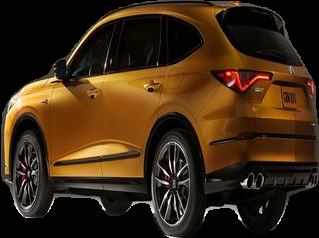

In [45]:
def extract_segment_image(path_to_read, path_to_write, segmentator):
    try:
      img_read = cv2.imread(path_to_read)
      bboxes, classes, segmentations, scores = segmentator.detect(img_read)
      # use this code to check that only necessary classes will be cropped
      for item, object_class in enumerate(classes):
            if object_class not in classes_ids:
                continue
            else:
                break
      points = np.array(segmentations[item])
      mask = np.zeros(img_read.shape[:2], dtype=np.uint8)
      cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
      img_segm = cv2.bitwise_and(img_read, img_read, mask=mask)
      (x, y, x2, y2) = bboxes[item]
      crop_img = img_segm[y:y2, x:x2]
      cv2_imshow(crop_img)
      img_name = path_to_read.split('/')[-1]
      cv2.imwrite(f'{path_to_write}{img_name}', crop_img)
    except Exception as err:
      print(f'с этим файлом что-то не так {path_to_read}, {err}')
      logger[path_to_read] = err
    return logger

extract_segment_image('/content/drive/MyDrive/Dataset_40_percentages/test/Acura_MDX/1_MDX_Acura_test.jpg', '/content/drive/MyDrive/TEST/', segmentator)

In [ ]:
# Creat new forders with segmented and cropped results
logger.clear()
path_to_read = '/content/drive/MyDrive/train/'
folders = os.listdir(path_to_read)
path_to_write = '/content/drive/MyDrive/TEST/'

for folder in folders[:2]:
  images = os.listdir(path_to_read + folder)
  os.makedirs(f'{path_to_write}{folder}/', exist_ok=True)
  for img in images:
    extract_segment_image(f'{path_to_read}{folder}/{img}', f'{path_to_write}{folder}/', segmentator)


0: 416x640 1 cat, 969.1ms
Speed: 2.4ms preprocess, 969.1ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)


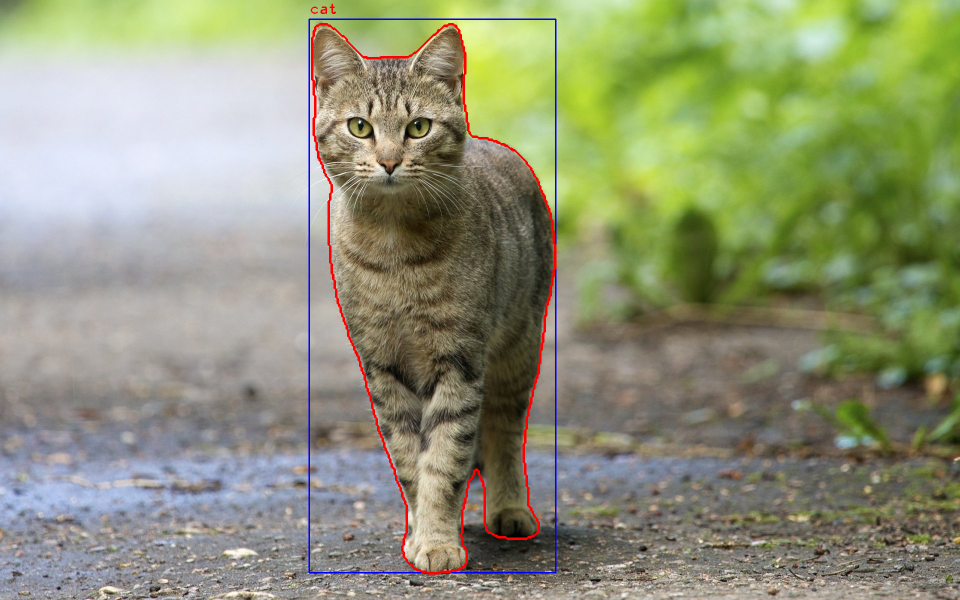

In [8]:
#To see the Yolo8 opportunities run it

from google.colab.patches import cv2_imshow
from skimage import io

def get_model_classes(model):
  return model.names

classes_names = get_model_classes(YOLO("yolov8n.pt"))
logger.clear()

def show_bboxes_contours_class_name(image_path, segmentator, from_url=False):
  try:
    if from_url:
      img_read = io.imread(image_path)
      img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    else:
      img_read = cv2.imread(image_path)

    bboxes, classes, segmentations, scores = segmentator.detect(img_read)
    for bbox, class_id, seg, score in zip(bboxes, classes, segmentations, scores):
        (x, y, x2, y2) = bbox
        cv2.rectangle(img_read, (x, y), (x2, y2), (255, 0, 0), 2)
        cv2.polylines(img_read, [seg], True, (0, 0, 255), 4)
        class_name = classes_names[class_id]
        edges = cv2.putText(img_read, class_name, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        scale_percent = 50 # percent of original size
        width = int(img_read.shape[1] * scale_percent / 100)
        height = int(img_read.shape[0] * scale_percent / 100)
        dim = (width, height)
        img_resized = cv2.resize(img_read, dim, interpolation = cv2.INTER_AREA)
        cv2_imshow(img_resized)
  except Exception as err:
      logger[image_path] = err
  return logger
  
  

# To detect from local storage
show_bboxes_contours_class_name('/content/a825274c3f23c6dc799fb1f1a713a44e.jpeg', YOLOSegmentation("yolov8m-seg.pt"))

# To detect from url
# show_bboxes_contours_class_name('https://legkovmeste.ru/wp-content/uploads/2019/02/post_5b03385e7aaa8.jpg', YOLOSegmentation("yolov8m-seg.pt"), from_url=True)